# Produce lifetime XY map

<i>
This notebook takes a clean kDST, measures the lifetime at
different points of the XY plane and stores this map in
a hdf5 file.
</i>

### Notebook configuration

In [1]:
run_number          = 5808
input_dst_filename  = f"$IC_DATA/RunIV/kdst_{run_number}_filtered.h5"
correction_filename = f"$IC_DATA/XYmaps/corrections_run{run_number}.h5"
plots_output_folder = f"plots/{run_number}/"

Zrange  =  100,  550
XYrange = -200,  200
Erange  =  2e3, 20e3
Qrange  =  100, 1500
Znbins  =   10
XYnbins =   60
Enbins  =  100
Qnbins  =  100

# Plotting style
default_cmap = "jet"
figure_size  = 16, 12
font_size    = 15

save_plots   = True
with_titles  = False
plots_format = "pdf"

### Imports

In [2]:
import os
import time
import collections

import tables            as tb
import numpy             as np
import matplotlib.pyplot as plt

import invisible_cities.core.fit_functions as fitf
import invisible_cities.reco.dst_functions as dstf
import invisible_cities.io  .kdst_io       as kdstio

from invisible_cities.core .core_functions import in_range
from invisible_cities.core .core_functions import weighted_mean_and_std
from invisible_cities.icaro. hst_functions import display_matrix
from invisible_cities.icaro. hst_functions import shift_to_bin_centers
from invisible_cities.icaro. hst_functions import measurement_string
from invisible_cities.icaro. hst_functions import plot_writer

from icaro.core.fit_functions import quick_gauss_fit
from icaro.core.fit_functions import fit_slices_2d_expo
from icaro.core.fit_functions import expo_seed
from icaro.core.fit_functions import to_relative
from icaro.core.fit_functions import conditional_labels

from table_info import RunInfo
from table_info import MapInfo

labels = conditional_labels(with_titles)

%matplotlib inline

### Initialization

In [3]:
Zbins     = np.linspace(* Zrange,  Znbins + 1)
Ebins     = np.linspace(* Erange,  Enbins + 1)
Qbins     = np.linspace(* Qrange,  Qnbins + 1)
XYbins    = np.linspace(*XYrange, XYnbins + 1)
XYcenters = shift_to_bin_centers(XYbins)
XYpitch   = np.diff(XYbins)[0]

input_dst_filename  = os.path.expandvars( input_dst_filename)
correction_filename = os.path.expandvars(correction_filename)

save = plot_writer(plots_output_folder, plots_format) if save_plots else lambda *x: None

plt.rcParams["figure.figsize"] = figure_size
plt.rcParams[  "font.size"   ] =   font_size

### Read data

In [4]:
dst           = dstf.load_dst(input_dst_filename, "DST", "Events")
unique_events = ~dst.event.duplicated()

number_of_S2s_full  = np.size         (unique_events)
number_of_evts_full = np.count_nonzero(unique_events)

print(f"Total number of S2s   : {number_of_S2s_full} ")
print(f"Total number of events: {number_of_evts_full}")

Total number of S2s   : 108387 
Total number of events: 106001


In [5]:
X = dst.X  .values
Y = dst.Y  .values
Z = dst.Z  .values
E = dst.S2e.values
Q = dst.S2q.values

### Event distribution

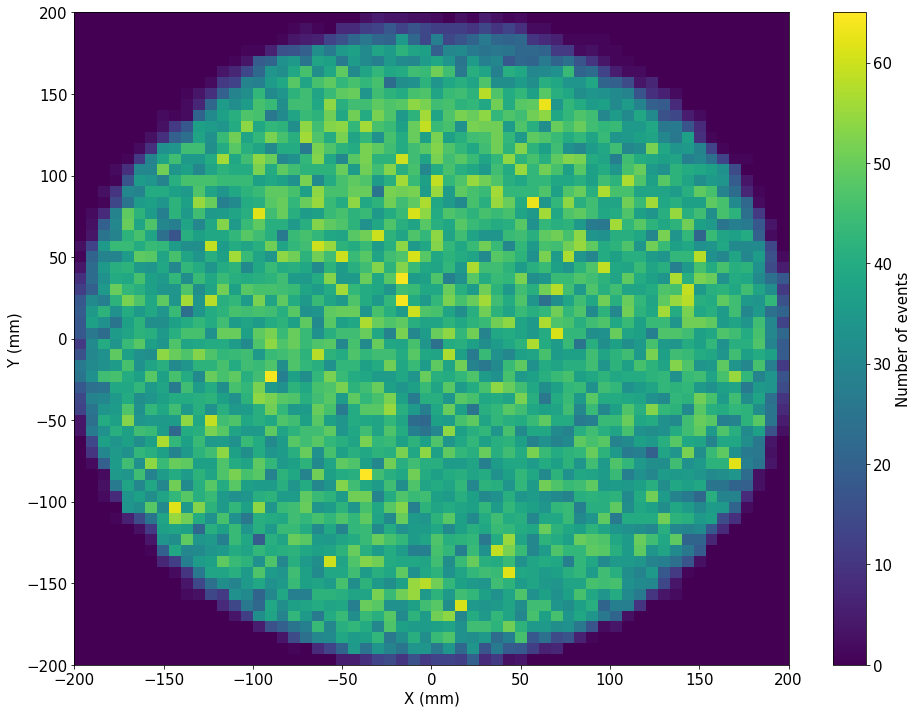

In [6]:
nevt, *_ = plt.hist2d(X, Y, (XYbins, XYbins))
plt.colorbar().set_label("Number of events")
labels("X (mm)", "Y (mm)", f"Event distribution for {XYpitch:.1f} mm pitch")
save(f"EventDistribution_{XYpitch:.1f}mm_XY")

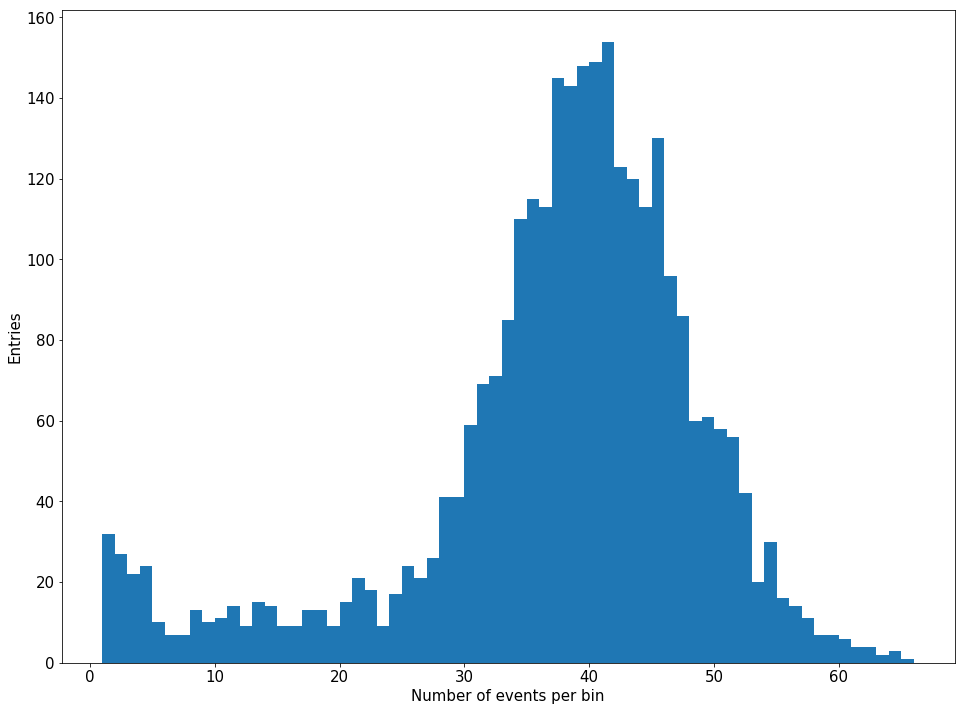

In [7]:
nevt_max = int(np.max(nevt))
plt.hist(nevt.flatten(), np.arange(1, nevt_max + 2))
labels("Number of events per bin", "Entries", "# events per bin")
save(f"EventDistribution_{XYpitch:.1f}mm")

### Fit examples

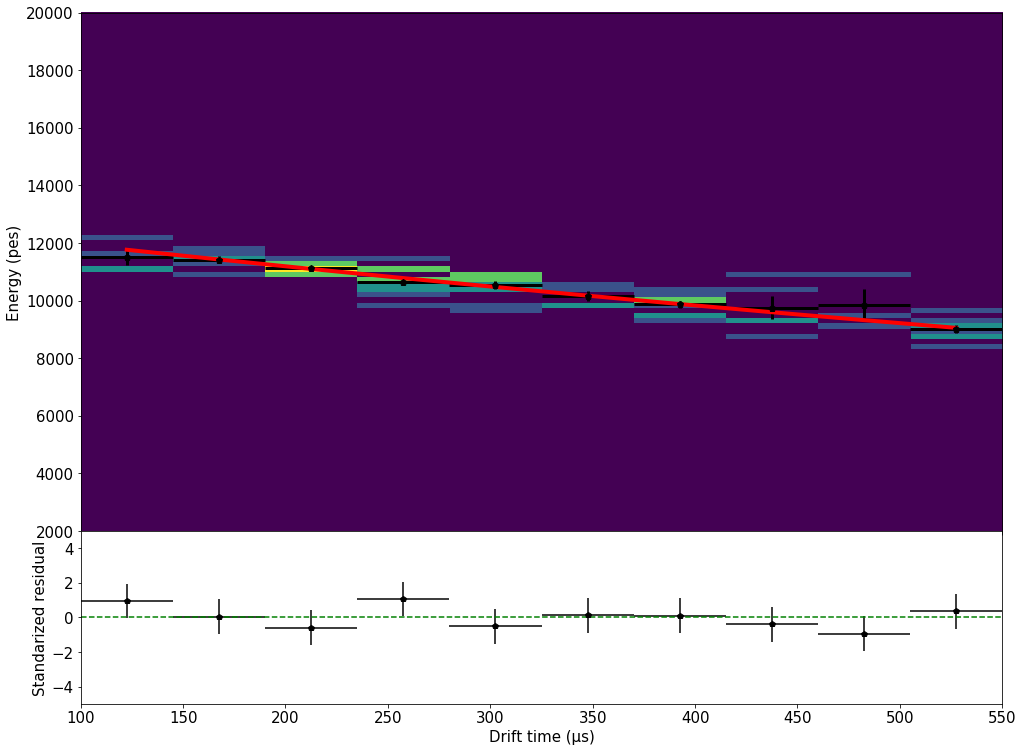

In [8]:
xlim =  15,  25
ylim = -25, -15
sel  = in_range(X, *xlim) & in_range(Y, *ylim)
z, e = Z[sel], E[sel]

frame_data = plt.gcf().add_axes((.1, .3,
                                 .8, .6))
plt.hist2d(z, e, (Zbins, Ebins))

x, y, yu = fitf.profileX(z, e, Znbins, Zrange)
plt.errorbar(x, y, yu, np.diff(x)[0]/2, fmt="kp", ms=7, lw=3)

seed = expo_seed(x, y)
f    = fitf.fit(fitf.expo, x, y, seed, sigma=yu)
plt.plot(x, f.fn(x), "r-", lw=4)

frame_data.set_xticklabels([])
labels("", "Energy (pes)", "Lifetime fit example")
lims = plt.xlim()

frame_res = plt.gcf().add_axes((.1, .1,
                                .8, .2))
plt.errorbar(x, (f.fn(x) - y) / yu, 1, np.diff(x)[0] / 2, fmt="p", c="k")
plt.plot(lims, (0, 0), "g--")
plt.xlim(*lims)
plt.ylim(-5, +5)
labels("Drift time (µs)", "Standarized residual")

save("Lifetime_fit_example")

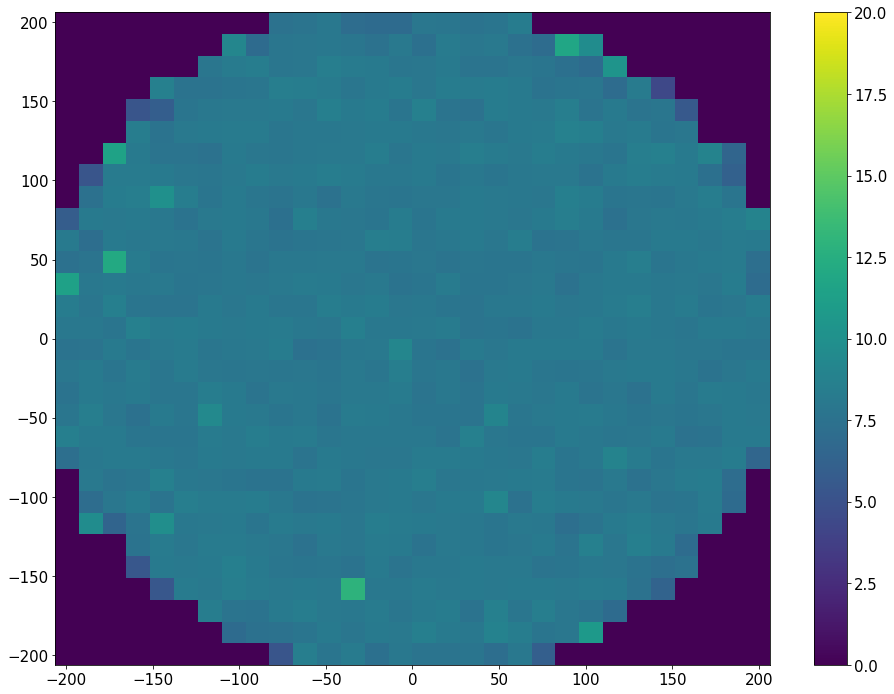

In [9]:
x, y, z, uz = fitf.profileXY(X, Y, dst.S1e, 30, 30, xrange=(-200, 200), yrange=(-200, 200))
display_matrix(x, y, z, vmin = 0, vmax=20);

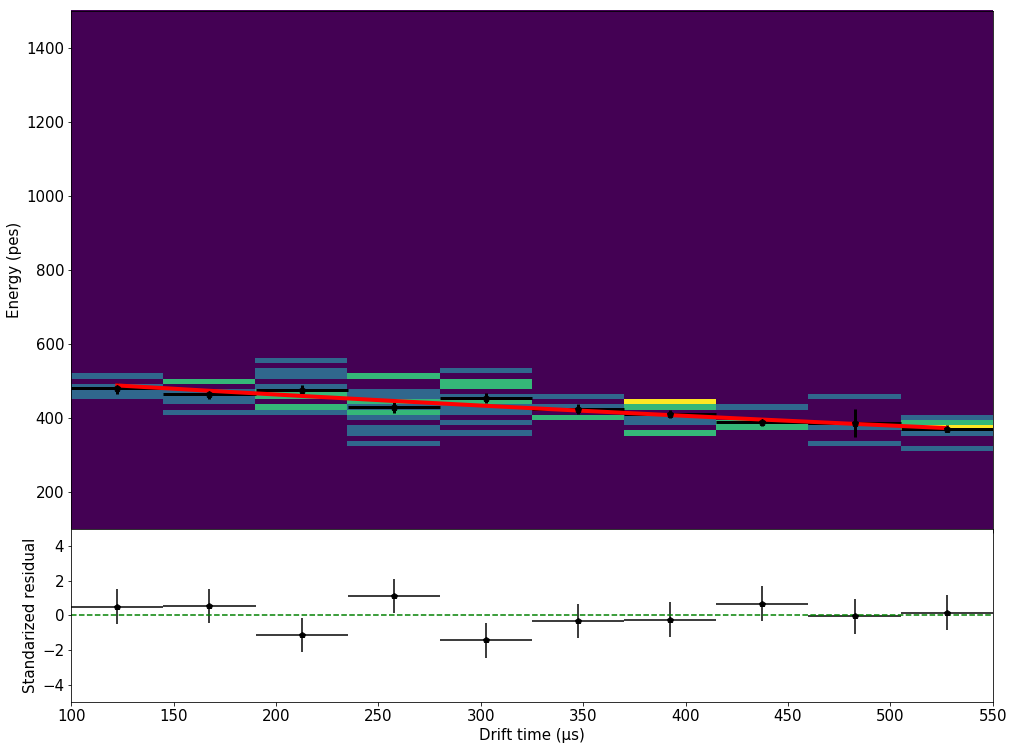

In [10]:
xlim =  15,  25
ylim = -25, -15
sel  = in_range(X, *xlim) & in_range(Y, *ylim)
z, q = Z[sel], Q[sel]

frame_data = plt.gcf().add_axes((.1, .3,
                                 .8, .6))
plt.hist2d(z, q, (Zbins, Qbins))

x, y, yu = fitf.profileX(z, q, Znbins, Zrange)
plt.errorbar(x, y, yu, np.diff(x)[0]/2, fmt="kp", ms=7, lw=3)

seed = expo_seed(x, y)
f    = fitf.fit(fitf.expo, x, y, seed, sigma=yu)
plt.plot(x, f.fn(x), "r-", lw=4)

frame_data.set_xticklabels([])
labels("", "Energy (pes)", "Lifetime fit example")
lims = plt.xlim()

frame_res = plt.gcf().add_axes((.1, .1,
                                .8, .2))
plt.errorbar(x, (f.fn(x) - y) / yu, 1, np.diff(x)[0] / 2, fmt="p", c="k")
plt.plot(lims, (0, 0), "g--")
plt.xlim(*lims)
plt.ylim(-5, +5)
labels("Drift time (µs)", "Standarized residual")

save("LifetimeQ_fit_example")

### Compute lifetime maps

In [11]:
Escale, ELT,\
Echi2, Eok = fit_slices_2d_expo(X, Y, Z, E, XYbins, XYbins, Znbins, zrange=Zrange, min_entries=50)
Eok        = Eok & (ELT.value < -100) & (ELT.value > -1e5) & np.isfinite(Echi2)
Escale_rel = to_relative(Escale, percentual=True)
ELT_rel    = to_relative(   ELT, percentual=True)

/Users/Gonzalo/github/ICARO/icaro/core/fit_functions.py:87: RuntimeWarning: invalid value encountered in greater
  valid_points = yu > 0


In [12]:
Qscale, QLT,\
Qchi2, Qok = fit_slices_2d_expo(X, Y, Z, Q, XYbins, XYbins, Znbins, zrange=Zrange, min_entries=50)
Qok        = Qok & (QLT.value < -100) & (QLT.value > -1e5) & np.isfinite(Qchi2)
Qscale_rel = to_relative(Qscale, percentual=True)
QLT_rel    = to_relative(   QLT, percentual=True)

/Users/Gonzalo/github/ICARO/icaro/core/fit_functions.py:87: RuntimeWarning: invalid value encountered in greater
  valid_points = yu > 0


In [13]:
ELT_min  = np.nanpercentile(-ELT    .value      [Eok],  0.0)
ELT_max  = np.nanpercentile(-ELT    .value      [Eok], 99.0)
ELTu_min = np.nanpercentile( ELT_rel.uncertainty[Eok],  0.1)
ELTu_max = np.nanpercentile( ELT_rel.uncertainty[Eok], 90.0)

E_min    = np.nanpercentile(Escale    .value      [Eok],  0.1)
E_max    = np.nanpercentile(Escale    .value      [Eok], 99.9)
Eu_min   = np.nanpercentile(Escale_rel.uncertainty[Eok],  0.1)
Eu_max   = np.nanpercentile(Escale_rel.uncertainty[Eok], 85.0)

QLT_min  = np.nanpercentile(-QLT    .value      [Qok],  0.0)
QLT_max  = np.nanpercentile(-QLT    .value      [Qok], 99.5)
QLTu_min = np.nanpercentile( QLT_rel.uncertainty[Qok],  0.1)
QLTu_max = np.nanpercentile( QLT_rel.uncertainty[Qok], 95.0)

Q_min    = np.nanpercentile(Qscale    .value      [Qok],  0.1)
Q_max    = np.nanpercentile(Qscale    .value      [Qok], 99.9)
Qu_min   = np.nanpercentile(Qscale_rel.uncertainty[Qok],  0.1)
Qu_max   = np.nanpercentile(Qscale_rel.uncertainty[Qok], 90.0)

print(ELT_min, ELT_max, ELTu_min, ELTu_max)
print(E_min  , E_max  , Eu_min  , Eu_max)
print(QLT_min, QLT_max, QLTu_min, QLTu_max)
print(Q_min  , Q_max  , Qu_min  , Qu_max)

966.612578016 2399.66597022 2.17357494527 8.43697545581
8464.39753189 13124.5780364 0.315083080814 1.58279478903
670.351820661 3872.98172364 2.06117122997 29.3683623408
414.252259886 728.886212932 0.681527421339 4.65018348271


### Map display

Average lifetime             (mean +- rms) = ((15.4 +- 3.0) · 1e2) µs
Average lifetime uncertainty (mean +- rms) = (5.2 +- 1.5) (%)


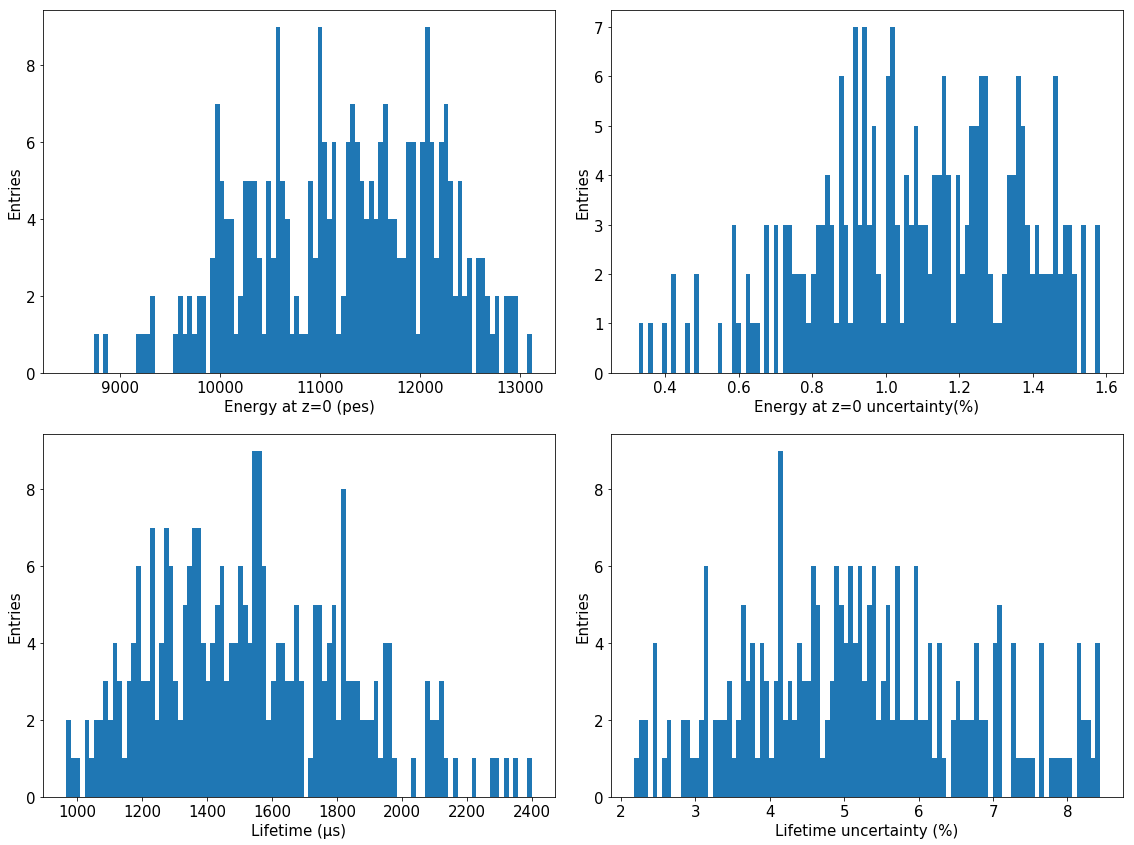

In [14]:
plt.subplot(2, 2, 1)
bins    = np.linspace(E_min, E_max, 101)
y, x, _ = plt.hist(Escale_rel.value[Eok], bins)
e_mean, e_std = weighted_mean_and_std(shift_to_bin_centers(x), y)
labels("Energy at z=0 (pes)", "Entries", "Energy scale distribution")

plt.subplot(2, 2, 2)
bins    = np.linspace(Eu_min, Eu_max, 101)
y, x, _ = plt.hist(Escale_rel.uncertainty[Eok], bins)
eu_mean, eu_std = weighted_mean_and_std(shift_to_bin_centers(x), y)
labels("Energy at z=0 uncertainty(%)", "Entries", "Energy scale uncertainty distribution")

plt.subplot(2, 2, 3)
bins    = np.linspace(ELT_min, ELT_max, 101)
y, x, _ = plt.hist(-ELT_rel.value[Eok], bins)
elt_mean, elt_std = weighted_mean_and_std(shift_to_bin_centers(x), y)
labels("Lifetime (µs)", "Entries", "Lifetime distribution")

plt.subplot(2, 2, 4)
bins    = np.linspace(ELTu_min, ELTu_max, 101)
y, x, _ = plt.hist(ELT_rel.uncertainty[Eok], bins)
eltu_mean, eltu_std = weighted_mean_and_std(shift_to_bin_centers(x), y)
labels("Lifetime uncertainty (%)", "Entries", "Lifetime uncertainty distribution")

plt.tight_layout()

save("Lifetime_and_energy_scale_distributions")

print("Average lifetime             (mean +- rms) = ({}) µs" .format(measurement_string( elt_mean,  elt_std)))
print("Average lifetime uncertainty (mean +- rms) = ({}) (%)".format(measurement_string(eltu_mean, eltu_std)))

Average lifetime             (mean +- rms) = ((15.3 +- 5.6) · 1e2) µs
Average lifetime uncertainty (mean +- rms) = (13.6 +- 5.5) (%)


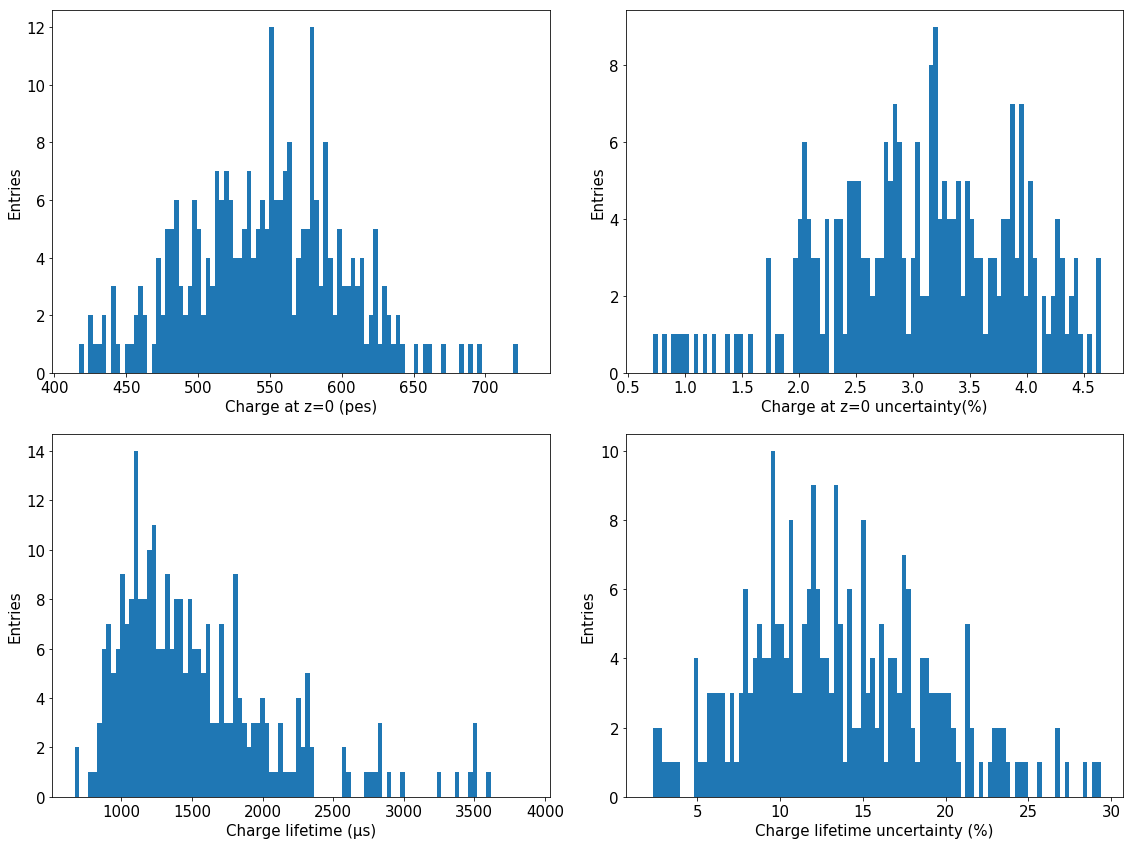

In [15]:
plt.subplot(2, 2, 1)
bins    = np.linspace(Q_min, Q_max, 101)
y, x, _ = plt.hist(Qscale_rel.value[Qok], bins)
q_mean, q_std = weighted_mean_and_std(shift_to_bin_centers(x), y)
labels("Charge at z=0 (pes)", "Entries", "Charge scale distribution")

plt.subplot(2, 2, 2)
bins    = np.linspace(Qu_min, Qu_max, 101)
y, x, _ = plt.hist(Qscale_rel.uncertainty[Qok], bins)
qu_mean, qu_std = weighted_mean_and_std(shift_to_bin_centers(x), y)
labels("Charge at z=0 uncertainty(%)", "Entries", "Charge scale uncertainty distribution")

plt.subplot(2, 2, 3)
bins    = np.linspace(QLT_min, QLT_max, 101)
y, x, _ = plt.hist(-QLT_rel.value[Qok], bins)
qlt_mean, qlt_std = weighted_mean_and_std(shift_to_bin_centers(x), y)
labels("Charge lifetime (µs)", "Entries", "Charge lifetime distribution")

plt.subplot(2, 2, 4)
bins    = np.linspace(QLTu_min, QLTu_max, 101)
y, x, _ = plt.hist(QLT_rel.uncertainty[Qok], bins)
qltu_mean, qltu_std = weighted_mean_and_std(shift_to_bin_centers(x), y)
labels("Charge lifetime uncertainty (%)", "Entries", "Charge lifetime uncertainty distribution")

plt.tight_layout()

save("Lifetime_and_charge_scale_distributions")

print("Average lifetime             (mean +- rms) = ({}) µs" .format(measurement_string( qlt_mean,  qlt_std)))
print("Average lifetime uncertainty (mean +- rms) = ({}) (%)".format(measurement_string(qltu_mean, qltu_std)))

/Applications/anaconda3/envs/IC3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6497: RuntimeWarning: invalid value encountered in greater
  h[h > cmax] = None


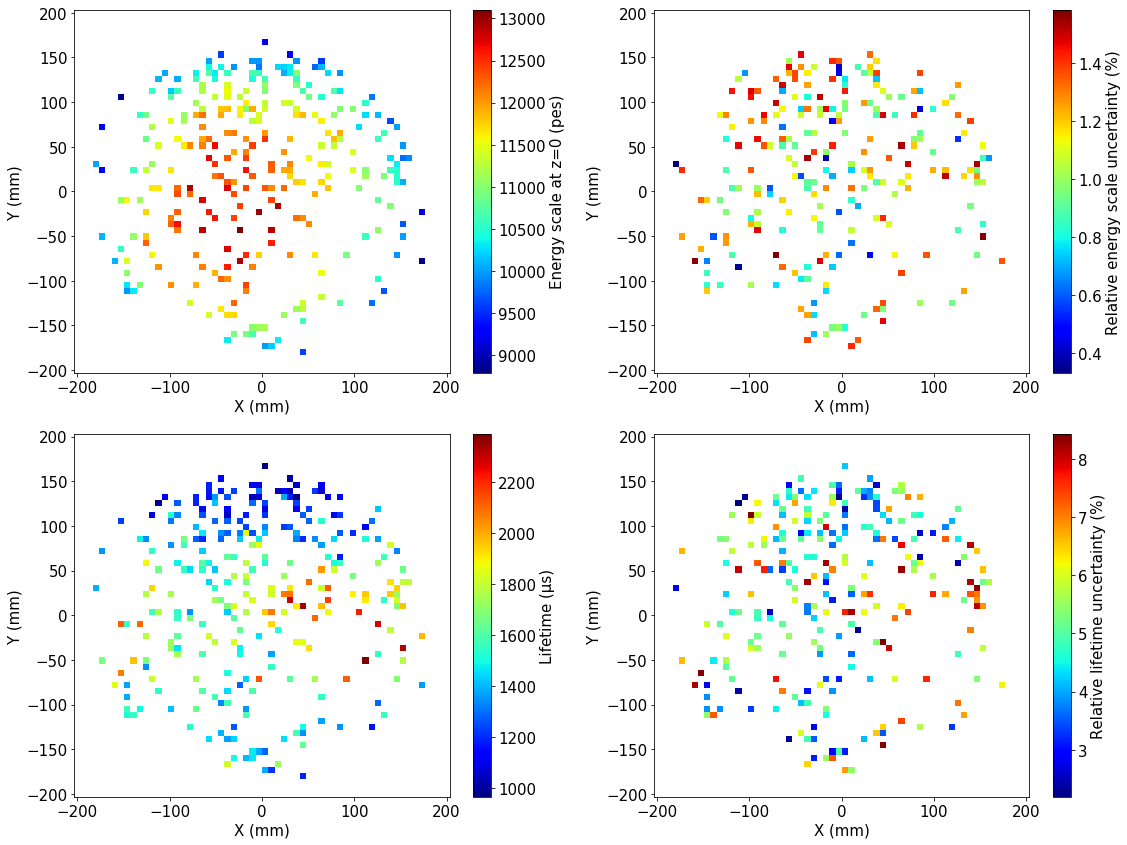

In [16]:
plt.subplot(2, 2, 1)
*_, cb = display_matrix(XYcenters, XYcenters, Escale_rel.value,
                        cmin = E_min,
                        cmax = E_max,
                        cmap = default_cmap,
                        new_figure = False);
cb.set_label("Energy scale at z=0 (pes)")
labels("X (mm)", "Y (mm)", "Energy scale")

plt.subplot(2, 2, 2)
*_, cb = display_matrix(XYcenters, XYcenters, Escale_rel.uncertainty,
                        cmin = Eu_min,
                        cmax = Eu_max,
                        cmap = default_cmap,
                        new_figure = False);
cb.set_label("Relative energy scale uncertainty (%)")
labels("X (mm)", "Y (mm)", "Relative energy scale uncertainty")

plt.subplot(2, 2, 3)
*_, cb = display_matrix(XYcenters, XYcenters, -ELT_rel.value,
                        cmin = ELT_min,
                        cmax = ELT_max,
                        cmap = default_cmap,
                        new_figure = False);
cb.set_label("Lifetime (µs)")
labels("X (mm)", "Y (mm)", "Lifetime")

plt.subplot(2, 2, 4)
*_, cb = display_matrix(XYcenters, XYcenters, ELT_rel.uncertainty,
                        cmin = ELTu_min,
                        cmax = ELTu_max,
                        cmap = default_cmap,
                        new_figure = False);
cb.set_label("Relative lifetime uncertainty (%)")
labels("X (mm)", "Y (mm)", "Relative lifetime uncertainty")

plt.tight_layout()
save("Lifetime_and_energy_scale_maps")

/Applications/anaconda3/envs/IC3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6497: RuntimeWarning: invalid value encountered in greater
  h[h > cmax] = None


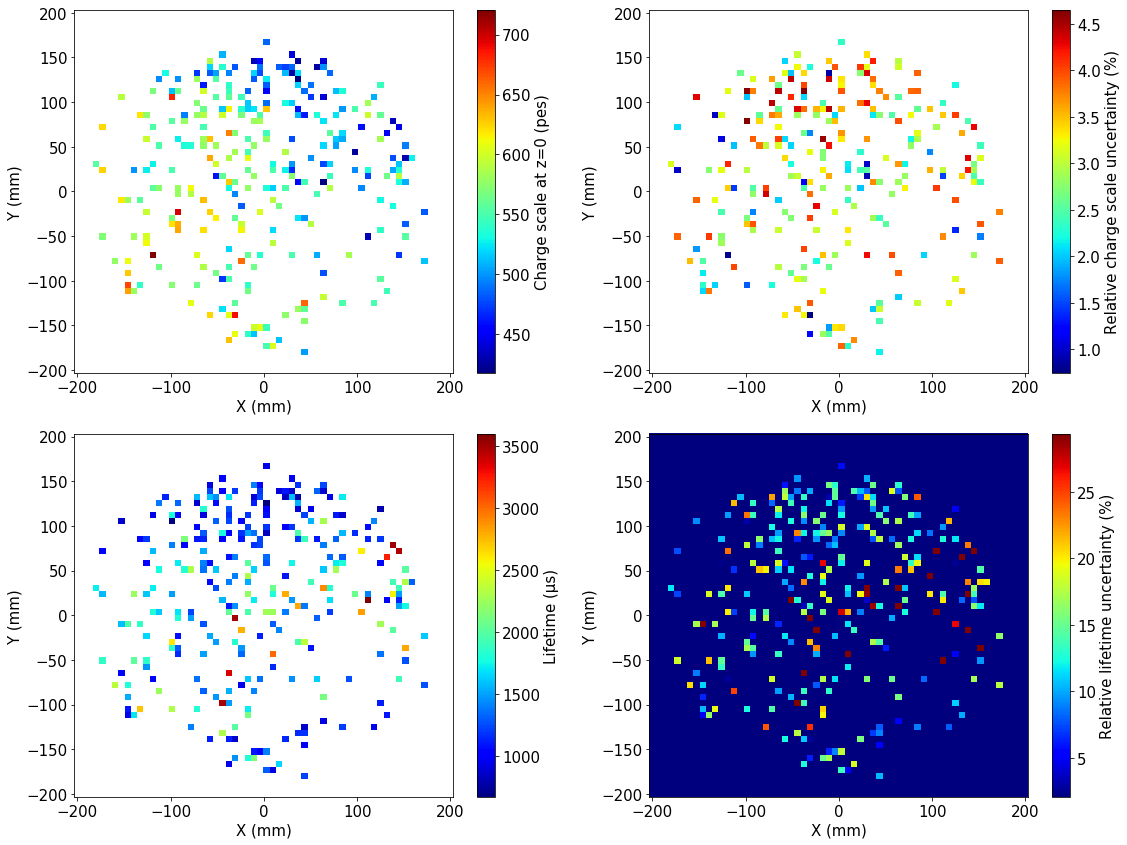

In [17]:
plt.subplot(2, 2, 1)
*_, cb = display_matrix(XYcenters, XYcenters, Qscale_rel.value,
                        cmin = Q_min,
                        cmax = Q_max,
                        cmap = default_cmap,
                        new_figure = False);
cb.set_label("Charge scale at z=0 (pes)")
labels("X (mm)", "Y (mm)", "Charge scale")

plt.subplot(2, 2, 2)
*_, cb = display_matrix(XYcenters, XYcenters, Qscale_rel.uncertainty,
                        cmin = Qu_min,
                        cmax = Qu_max,
                        cmap = default_cmap,
                        new_figure = False);
cb.set_label("Relative charge scale uncertainty (%)")
labels("X (mm)", "Y (mm)", "Relative charge scale uncertainty")

plt.subplot(2, 2, 3)
*_, cb = display_matrix(XYcenters, XYcenters, -QLT_rel.value,
                        cmin = QLT_min,
                        cmax = QLT_max,
                        cmap = default_cmap,
                        new_figure = False);
cb.set_label("Lifetime (µs)")
labels("X (mm)", "Y (mm)", "Lifetime")

plt.subplot(2, 2, 4)
*_, cb = display_matrix(XYcenters, XYcenters, QLT_rel.uncertainty,
                        vmin = QLTu_min,
                        vmax = QLTu_max,
                        cmap = default_cmap,
                        new_figure = False);
cb.set_label("Relative lifetime uncertainty (%)")
labels("X (mm)", "Y (mm)", "Relative lifetime uncertainty")

plt.tight_layout()
save("Lifetime_and_charge_scale_maps")

In [18]:
Echi2_min = np.nanpercentile(Echi2[Echi2 > 0],  0.0)
Echi2_max = np.nanpercentile(Echi2           , 99.0)

Qchi2_min = np.nanpercentile(Qchi2[Qchi2 > 0],  0.0)
Qchi2_max = np.nanpercentile(Qchi2           , 99.0)

print(Echi2_min, Echi2_max)
print(Qchi2_min, Qchi2_max)

0.172040841441 3.51020512387
0.193026676632 4.35933163021


/Applications/anaconda3/envs/IC3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6497: RuntimeWarning: invalid value encountered in greater
  h[h > cmax] = None


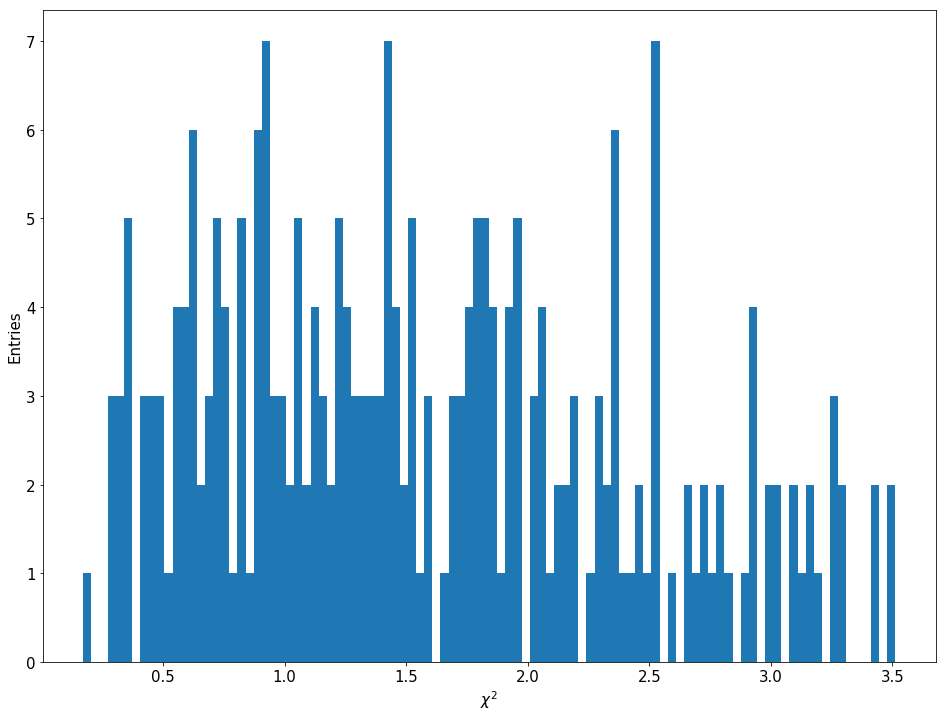

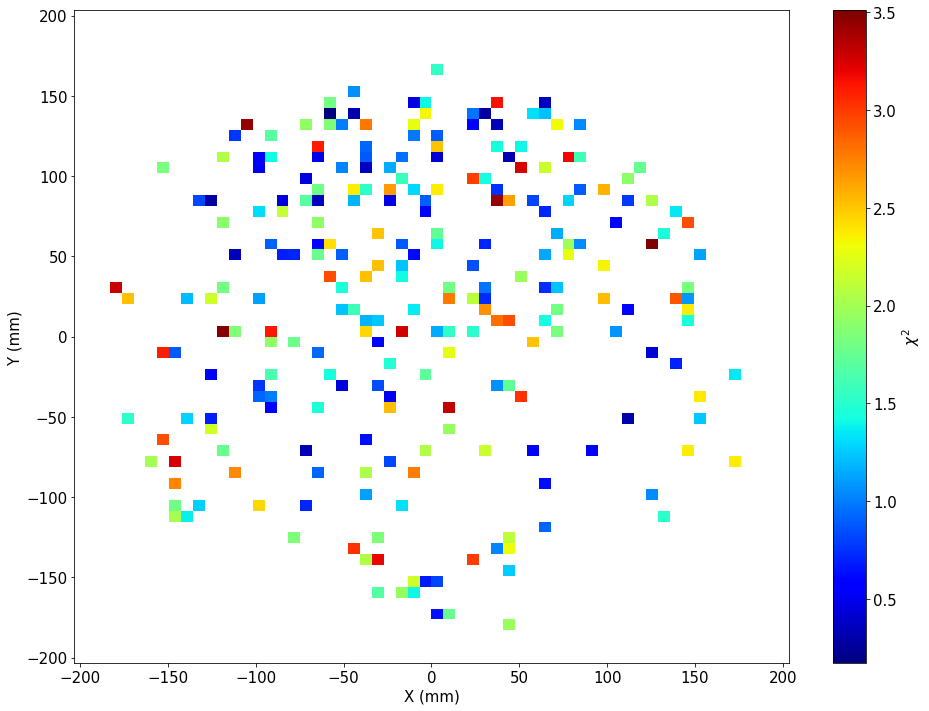

In [19]:
bins = np.linspace(Echi2_min, Echi2_max, 101)
plt.hist(Echi2[Eok], bins)
labels("$\chi^2$", "Entries", "$\chi^2$ distribution")

*_, cb = display_matrix(XYcenters, XYcenters, Echi2.flatten(),
                        cmin = Echi2_min,
                        cmax = Echi2_max,
                        cmap = default_cmap)
cb.set_label("$\chi^2$")
labels("X (mm)", "Y (mm)", "$\chi^2$ vs XY")

/Applications/anaconda3/envs/IC3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6497: RuntimeWarning: invalid value encountered in greater
  h[h > cmax] = None


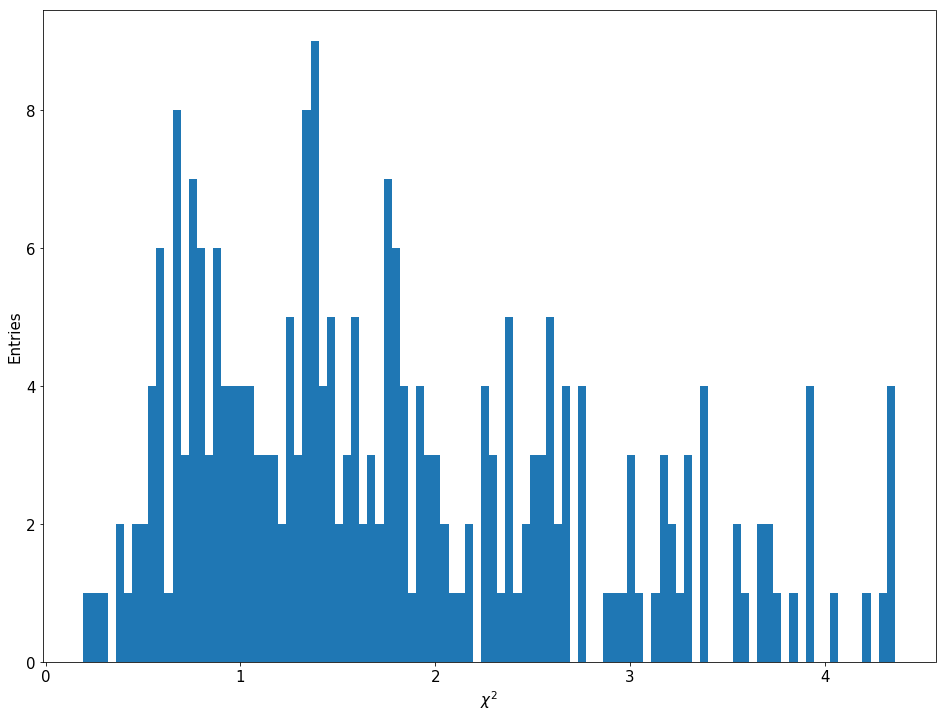

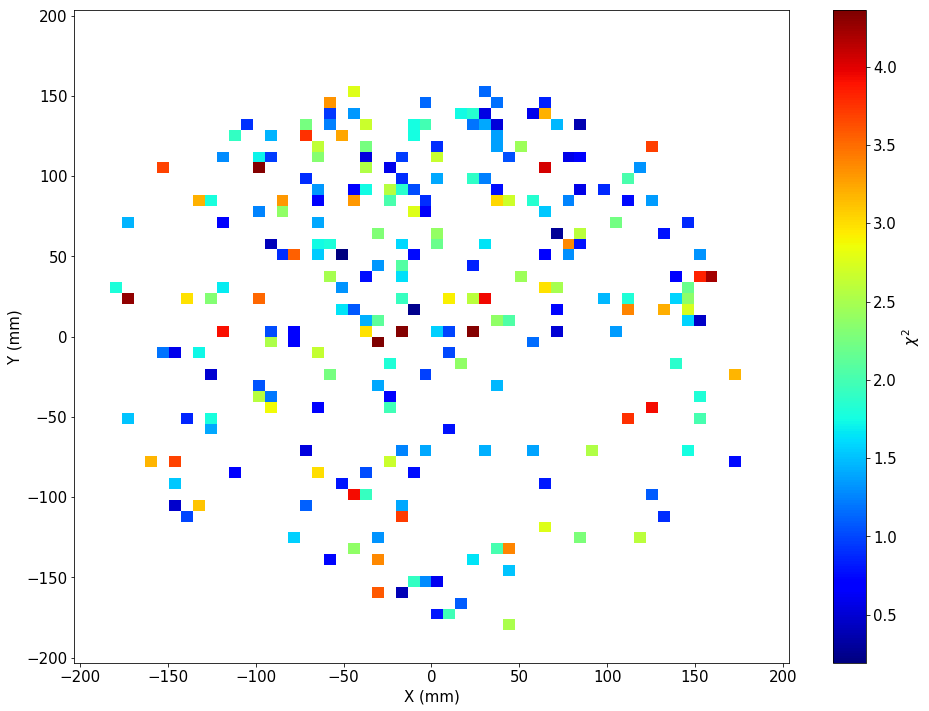

In [20]:
bins = np.linspace(Qchi2_min, Qchi2_max, 101)
plt.hist(Qchi2[Qok], bins)
labels("$\chi^2$", "Entries", "$\chi^2$ distribution")

*_, cb = display_matrix(XYcenters, XYcenters, Qchi2.flatten(),
                        cmin = Qchi2_min,
                        cmax = Qchi2_max,
                        cmap = default_cmap)
cb.set_label("$\chi^2$")
labels("X (mm)", "Y (mm)", "$\chi^2$ vs XY")

### Produce HDF5 output

In [21]:
t_min = int(dst.time.values.min())
t_max = int(dst.time.values.max())
with tb.open_file(correction_filename, "w") as correction_file:
    run_table = correction_file.create_table(correction_file.root, "RunInfo"  , RunInfo, "Run metadata")
    map_table = correction_file.create_table(correction_file.root, "LTMapInfo", MapInfo, "Map metadata")

    row = run_table.row
    row["run_number"] = run_number
    row["t_min"     ] = t_min
    row["t_max"     ] = t_max
    row.append()

    row = map_table.row
    row["x_nbins"] = XYnbins
    row["y_nbins"] = XYnbins
    row["x_pitch"] = XYpitch
    row["y_pitch"] = XYpitch
    row["x_min"  ] = XYrange[0]
    row["x_max"  ] = XYrange[1]
    row["y_min"  ] = XYrange[0]
    row["y_max"  ] = XYrange[1]
    row.append()

In [22]:
# This is to avoid the effect of low stat bins
# to the map. Data points in that bin could be
# loss or corrected with an unrealistic lifetime.
# Thus, we assign the average value. This works
# because correcting with a slightly different
# lifetime does not have a big impact on energy
# resolution.

Escale_safe  = np.where(Eok, Escale.value      ,    e_mean)
Escaleu_safe = np.where(Eok, Escale.uncertainty,   eu_mean *   e_mean / 100)

ELT_safe     = np.where(Eok,   -ELT.value      ,  elt_mean)
ELTu_safe    = np.where(Eok,    ELT.uncertainty, eltu_mean * elt_mean / 100)

Qscale_safe  = np.where(Qok, Qscale.value      ,    q_mean)
Qscaleu_safe = np.where(Qok, Qscale.uncertainty,   qu_mean *   q_mean / 100)

QLT_safe     = np.where(Qok,   -QLT.value      ,  qlt_mean)
QLTu_safe    = np.where(Qok,    QLT.uncertainty, qltu_mean * qlt_mean / 100)

with tb.open_file(correction_filename, "a") as correction_file:    
    write_escale = kdstio.xy_writer(correction_file,
                                    group       = "XYcorrections",
                                    name        = "Escale",
                                    description = "XY-dependent energy scale",
                                    compression = "ZLIB4")
    write_escale(XYcenters, XYcenters, Escale_safe, Escaleu_safe, nevt)

    write_lifetime = kdstio.xy_writer(correction_file,
                                      group       = "XYcorrections",
                                      name        = "Elifetime",
                                      description = "XY-dependent lifetime values",
                                      compression = "ZLIB4")
    write_lifetime(XYcenters, XYcenters, ELT_safe, ELTu_safe, nevt)

    write_qscale = kdstio.xy_writer(correction_file,
                                    group       = "XYcorrections",
                                    name        = "Qscale",
                                    description = "XY-dependent energy scale",
                                    compression = "ZLIB4")
    write_escale(XYcenters, XYcenters, Qscale_safe, Qscaleu_safe, nevt)

    write_lifetime = kdstio.xy_writer(correction_file,
                                      group       = "XYcorrections",
                                      name        = "Qlifetime",
                                      description = "XY-dependent lifetime values",
                                      compression = "ZLIB4")
    write_lifetime(XYcenters, XYcenters, QLT_safe, QLTu_safe, nevt)
